In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import joblib
from google.colab import files
import io
from xgboost import XGBClassifier
import xgboost as xgb
from imblearn.over_sampling import SMOTE

In [3]:
uploaded = files.upload()
print(uploaded.keys())
file_name = next(iter(uploaded))
data = pd.read_csv(io.BytesIO(uploaded[file_name]))
print(data.head())

Saving kindey stone urine analysis - xgb.csv to kindey stone urine analysis - xgb.csv
dict_keys(['kindey stone urine analysis - xgb.csv'])
   gravity    ph  osmo  cond  urea  calc  target
0    1.021  4.91   725  14.0   443  2.45       0
1    1.017  5.74   577  20.0   296  4.49       0
2    1.008  7.20   321  14.9   101  2.36       0
3    1.011  5.51   408  12.6   224  2.15       0
4    1.005  6.52   187   7.5    91  1.16       0


In [4]:
print(data.columns)

Index(['gravity', 'ph', 'osmo', 'cond', 'urea', 'calc', 'target'], dtype='object')


In [6]:
features = ['gravity', 'ph', 'osmo', 'cond', 'urea', 'calc']
X = data[features]
y = data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print(X.head())


   gravity    ph  osmo  cond  urea  calc
0    1.021  4.91   725  14.0   443  2.45
1    1.017  5.74   577  20.0   296  4.49
2    1.008  7.20   321  14.9   101  2.36
3    1.011  5.51   408  12.6   224  2.15
4    1.005  6.52   187   7.5    91  1.16


In [7]:
from sklearn.metrics import accuracy_score, classification_report
xg_model = xgb.XGBClassifier(random_state=42, eval_metric='logloss')
xg_model.fit(X_train_scaled, y_train)
y_pred = xg_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy of the XGBoost model: {accuracy:.2f}')
print("Classification Report:")
print(classification_report(y_test, y_pred))


Accuracy of the XGBoost model: 0.94
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.89      0.94        19
           1       0.87      1.00      0.93        13

    accuracy                           0.94        32
   macro avg       0.93      0.95      0.94        32
weighted avg       0.95      0.94      0.94        32



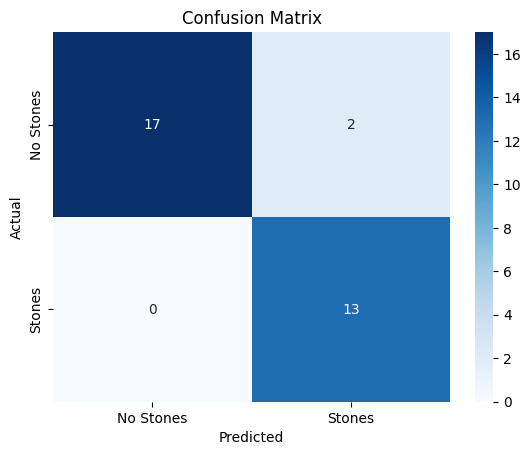

In [8]:
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Stones', 'Stones'], yticklabels=['No Stones', 'Stones'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

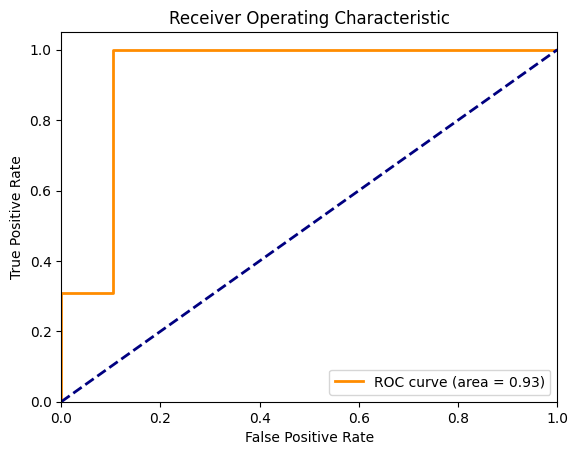

In [9]:
fpr, tpr, thresholds = roc_curve(y_test, xg_model.predict_proba(X_test_scaled)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [10]:
joblib.dump(xg_model, 'xg_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
loaded_model = joblib.load('xg_model.pkl')
loaded_scaler = joblib.load('scaler.pkl')
X_scaled = loaded_scaler.transform(X)
predictions = loaded_model.predict(X_scaled)
print("Predictions on full data:", predictions)


Predictions on full data: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1]


In [11]:

skf = StratifiedKFold(n_splits=3)
scores = cross_val_score(xg_model, X, y, cv=skf)
print(f'Cross-validation scores: {scores}')


/usr/local/lib/python3.11/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The XGBClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


AttributeError: 'super' object has no attribute '__sklearn_tags__'

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}


In [ ]:
grid_search = GridSearchCV(estimator=xg_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train_scaled, y_train)
print("Best Parameters:", grid_search.best_params_)


AttributeError: 'super' object has no attribute '__sklearn_tags__'

In [ ]:
grid_search = GridSearchCV(
    estimator=xg_model,
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)


In [ ]:
print(X_test_scaled.shape)


(32, 6)


In [ ]:
from sklearn.metrics import accuracy_score
y_pred = xg_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy of the XGBoost model: {accuracy:.2f}')


NotFittedError: need to call fit or load_model beforehand

In [ ]:
from sklearn.metrics import accuracy_score
y_pred = xg_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy of the XGBoost model: {accuracy:.2f}')


Accuracy of the XGBoost model: 0.94


In [ ]:
best_xg_model = grid_search.best_estimator_
y_pred = best_xg_model.predict(X_test_scaled)
print("Best Model Classification Report:")
print(classification_report(y_test, y_pred))

AttributeError: 'GridSearchCV' object has no attribute 'best_estimator_'

In [ ]:
feature_importances = pd.DataFrame(best_xg_model.feature_importances_, index=X.columns, columns=['Importance']).sort_values('Importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances['Importance'], y=feature_importances.index)
plt.title('Feature Importance for Kidney Stone Prediction')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

NameError: name 'best_xg_model' is not defined

In [ ]:
best_xg_model = grid_search.best_estimator_
y_pred = best_xg_model.predict(X_test_scaled)
print("Best Model Classification Report:")
print(classification_report(y_test, y_pred))

AttributeError: 'GridSearchCV' object has no attribute 'best_estimator_'

In [ ]:
feature_importances = pd.DataFrame(best_xg_model.feature_importances_, index=X.columns, columns=['Importance']).sort_values('Importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances['Importance'], y=feature_importances.index)
plt.title('Feature Importance for Kidney Stone Prediction')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

NameError: name 'best_xg_model' is not defined